I am using the US Airbnb Datasets. We will be utilizing the dataset to build a model which will attempt to predict prices based on Description using NLP and Sentiment Analysis.

In [1]:
# Data exploration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

In [2]:
df = pd.read_csv('AB_US_2020.csv')

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [4]:
# Review columns to be used, and drop the rest
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city'],
      dtype='object')

In [5]:
# Name represents the description of the listing
df_n = df.drop(columns=['host_id', 'host_name', 'neighbourhood_group','neighbourhood', 'latitude', 'longitude', 'room_type','minimum_nights', 'number_of_reviews', 'last_review','reviews_per_month', 'calculated_host_listings_count','availability_365'], inplace=True)

In [6]:
df.head()

,id,name,price,city
0,38585,Charming Victorian home - twin beds + breakfast,60,Asheville
1,80905,French Chic Loft,470,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,75,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,90,Asheville
4,160594,Historic Grove Park,125,Asheville


Start of NLP

In [10]:
# imports
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re

# define function tokenize

def tokenize(text):
    '''
    for text strings to be tokenized (tokens)
    removing stop words
    Lemmatization
    '''
    tokens = word_tokenize(text)
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markmorelos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['name'].value_counts(normalize=True)[:10]

Home away from home                                0.000332
A place of your own | 2BR in Las Vegas             0.000274
Cozy place to call home | 1BR in Los Angeles       0.000212
Stay in a place of your own | 1BR in Washington    0.000190
Union Square Convention Hotel                      0.000177
Home Away From Home                                0.000164
Well-equipped apartment home | 1BR in Boston       0.000159
A place of your own | 1BR in Las Vegas             0.000159
Private room                                       0.000155
Cozy place to call home | 2BR in Los Angeles       0.000155
Name: name, dtype: float64

In [12]:
# Using the tokenize function
df['name'] = df['name'].apply(str)
df['base_tokens'] = df['name'].apply(tokenize)
df['base_tokens'].head()

0    [charming, victorian, home, twin, bed, breakfast]
1                                 [french, chic, loft]
2    [walk, storesparksdowntown, fenced, yardpets, ok]
3                  [cottage, bonpaul, sharkys, hostel]
4                              [historic, grove, park]
Name: base_tokens, dtype: object

In [13]:
df[['name', 'base_tokens']][:10]

,name,base_tokens
0,Charming Victorian home - twin beds + breakfast,"[charming, victorian, home, twin, bed, breakfast]"
1,French Chic Loft,"[french, chic, loft]"
2,Walk to stores/parks/downtown. Fenced yard/Pet...,"[walk, storesparksdowntown, fenced, yardpets, ok]"
3,Cottage! BonPaul + Sharky's Hostel,"[cottage, bonpaul, sharkys, hostel]"
4,Historic Grove Park,"[historic, grove, park]"
5,Terrace Cottage,"[terrace, cottage]"
6,Blue Gate West,"[blue, gate, west]"
7,Asheville Dreamer's Cabin,"[asheville, dreamer, cabin]"
8,"Private, peaceful, and free goat therapy","[private, peaceful, free, goat, therapy]"
9,The Fern Street Apt near Biltmore,"[fern, street, apt, near, biltmore]"


Analyzing tokens

In [14]:
# Create a function which takes a corpus of document and returns a dataframe of word counts

from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [15]:
wc = count(df['base_tokens'])
print(wc.shape)
wc.head()

(49297, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
28,private,25945,26612,1.0,0.021842,0.021842,0.114786
81,room,26159,26422,2.0,0.021687,0.043529,0.115732
357,bedroom,22836,22941,3.0,0.018829,0.062358,0.101031
4,home,18724,19926,4.0,0.016355,0.078713,0.082839
3364,beach,15356,16141,5.0,0.013248,0.091961,0.067938


Visualizing with Comment Clouds

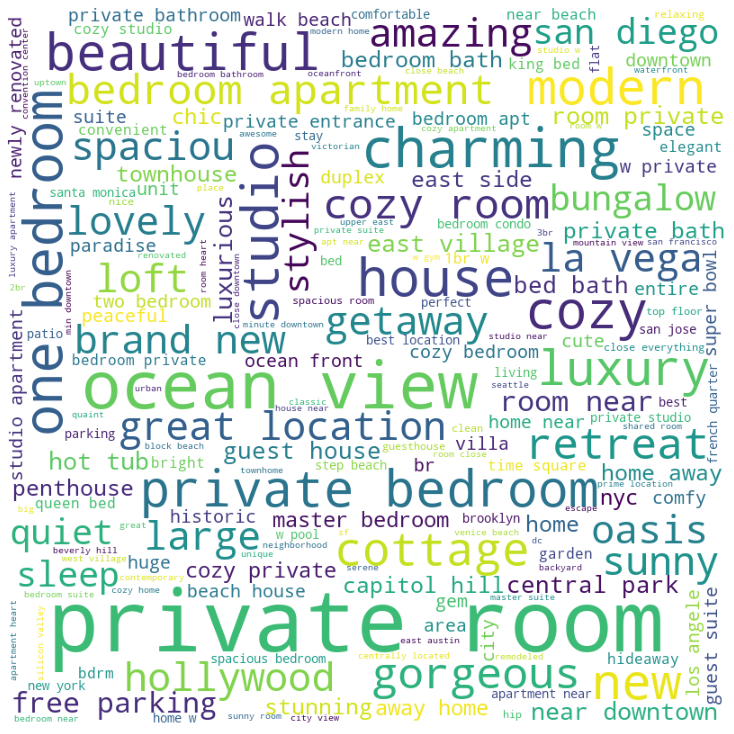

In [17]:
from wordcloud import WordCloud

comment_words = ''
stop_words = set(stopwords.words('english'))

for val in df.base_tokens:
    val = str(val)
    tokens = word_tokenize(val)
    tokens = re.sub('[^a-zA-Z 0-9]', '', val)
    tokens = tokens.lower().split()
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                     background_color='white',
                     stopwords = stop_words,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Price Prediction Model based on Description

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# initialize pipeline

# Create pipeline components
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
svm = LinearSVC()

# Get sparse dtm
dtm = vect.fit_transform(df.name)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

pipe = Pipeline([
    ('vect', vect),
    ('clf', svm)
])

# split data and remove NA values
df.dropna(inplace=True)
X = df['name']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
           

In [24]:
y_preds = pipe.predict(X_test)
y_preds

array([ 32, 115,  45, ..., 500, 197, 199])

In [25]:
mse = mean_squared_error(y_test, y_preds)
mse

363702.8575852763

In [26]:
from math import sqrt

rmse = sqrt(mse)
rmse

603.0778205051785

In [27]:
y_test.head(10)

68404     132
6903      260
92949      79
195137     68
78425     142
26        305
188220    215
185623     75
63553     125
65552      79
Name: price, dtype: int64

In [28]:
r2 = r2_score(y_test, y_preds)
r2

-0.2862074826534151